# Load libraries

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import keras
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import csv    

import cv2
import os
import numpy as np
import time
from keras.models import Model,model_from_json
from segmentation import predict
import tensorflow as tf
import glob
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(get_session())

/Users/leeunseok/anaconda/envs/data_science/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load a segmentation module of nodule in soybean root

In [2]:
checkpoint_dir='./segmentation/checkpoint/UNET/190528_bean'
t_start = cv2.getTickCount()
print (os.path.join(checkpoint_dir, 'model.json'))
with open(os.path.join(checkpoint_dir, 'model.json'), 'r') as json_file:
        loaded_model_json = json_file.read()
segmentation_model = model_from_json(loaded_model_json)
weight_list = sorted(glob.glob(os.path.join(checkpoint_dir, "*.h5")))
print(weight_list)
segmentation_model.load_weights(weight_list[-1])
print ("[*] model load : %s"%weight_list[-1])
t_total = (cv2.getTickCount() - t_start) / cv2.getTickFrequency() * 1000 
print ("[*] model loading Time: %.3f ms"%t_total)

./segmentation/checkpoint/UNET/190528_bean/model.json
['./segmentation/checkpoint/UNET/190528_bean/weights.990.h5']
[*] model load : ./segmentation/checkpoint/UNET/190528_bean/weights.990.h5
[*] model loading Time: 7063.202 ms


# Segmentation and detection of nodules

In [3]:
my_csv = open('./results.csv', 'wb')
wr = csv.writer(my_csv)
wr.writerow(['group_name', "file_name", 'nodule_name','nodule_size(pixels)'])


./test_root_data/

./test_root_data/302 ts Soil
302 ts Soil


segmentation/predict.py:23: RuntimeWarning: divide by zero encountered in log
  U = -np.log(output_probs)


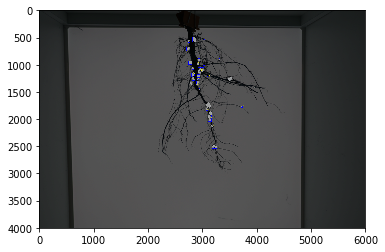

./test_root_data/205 ps Water
205 ps Water


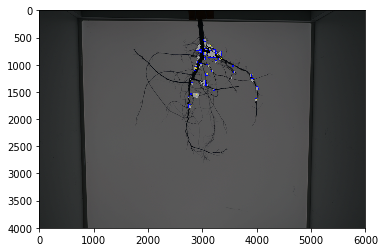

./test_root_data/203 ts Water
203 ts Water


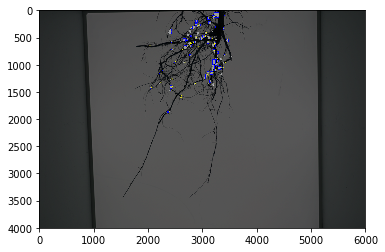

./test_root_data/201 ts Soil
201 ts Soil


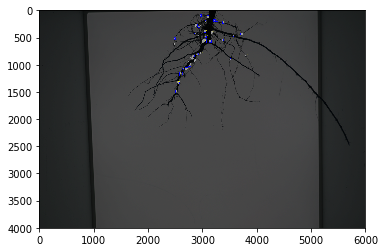

./test_root_data/104 ps Soil
104 ps Soil


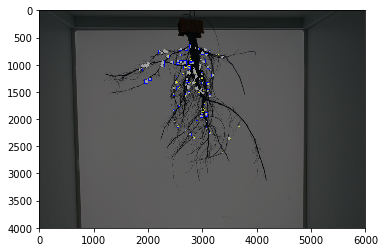

./test_root_data/101 ts Water
101 ts Water


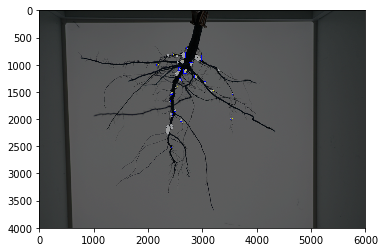

./test_root_data/106 ps Water
106 ps Water


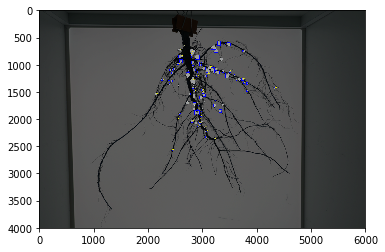

./test_root_data/103 ts Soil+Leaf
103 ts Soil+Leaf


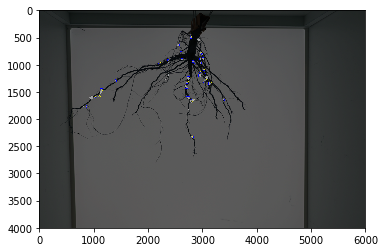

./test_root_data/102 ts Soil
102 ts Soil


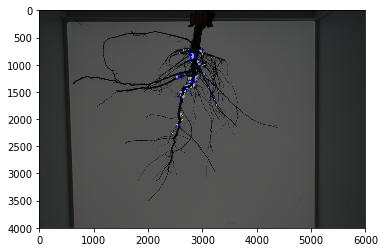

./test_root_data/303 ps Soil+Leaf
303 ps Soil+Leaf


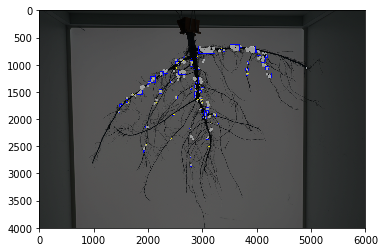

./test_root_data/305 ps Water
305 ps Water


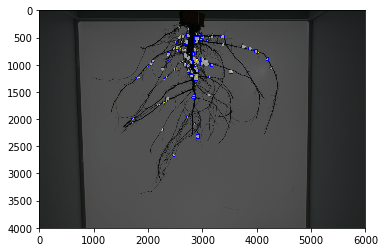

./test_root_data/204 ps Soil+Leaf
204 ps Soil+Leaf


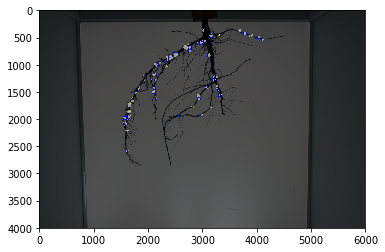

./test_root_data/206 ps Soil
206 ps Soil


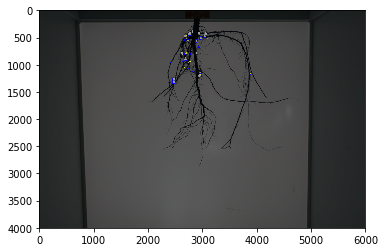

./test_root_data/105 ps Soil+Leaf
105 ps Soil+Leaf


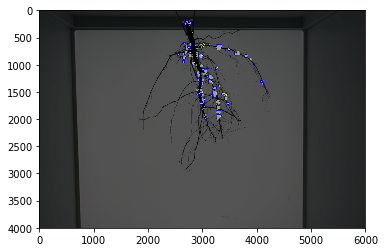

./test_root_data/304 ts Water
304 ts Water


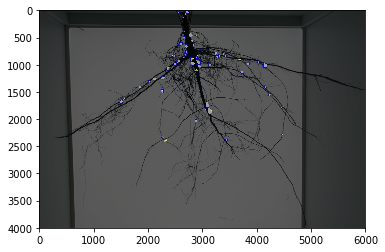

./test_root_data/301 ts Soil+Leaf
301 ts Soil+Leaf


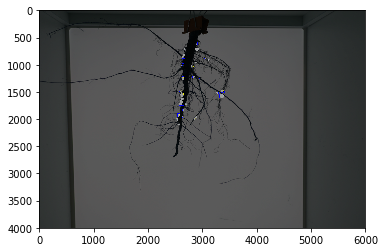

./test_root_data/202 ts Soil+Water
202 ts Soil+Water


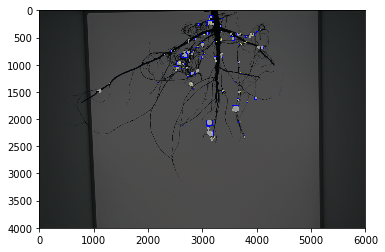

./test_root_data/306 ps Soil
306 ps Soil


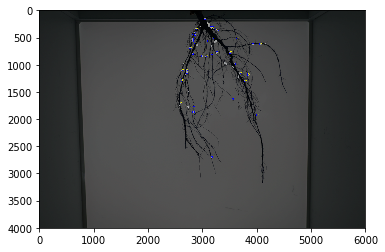

In [4]:

for r,d,ff in os.walk('./test_root_data/'):
    
    print r
    files = glob.glob(r + '/*.JPG') 
    files = sorted(files)
    group_name = r.split('/')[-1]
    print group_name
    for f in files:
        fname=f.split('/')[-1].split('.')[0]
        ret_img, ret_mask=predict.custom_predict(model=segmentation_model,image_path=f,result_fname='./segmentation/result.png',img_size=1024.0)
        save_path = r + '/results'

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        cv2.imwrite(save_path + '/' + fname + '.png',ret_img)
        cv2.imwrite(save_path + '/' + fname + '_mask.png',ret_mask)

        thresh = threshold_otsu(ret_mask)
        bw = closing(ret_mask > thresh, square(3))
        cleared = clear_border(bw)

        blobs_labels = label(cleared, background=0)
        new_img = cv2.imread(save_path + '/' + fname + '.png',1)
        new_mask = cv2.imread(save_path + '/' + fname + '_mask.png',1)
        overlay_img =cv2.addWeighted(new_img,0.5,new_mask,0.6,0.0)
        areas=[]
        blob_cnt=1
        for region in regionprops(blobs_labels):
            if region.area >= 50:
                areas.append(region.area)
        
                minr, minc, maxr, maxc = region.bbox
                x1= minc
                y1 = minr

                x2=maxc
                y2=maxr

                cx = int((x1+x2) / 2.0)
                cy = int((y1+y2)/ 2.0)
                overlay_img=cv2.rectangle(overlay_img,(x1,y1),(x2,y2),(0,0,255),3)
                cv2.putText(overlay_img,str(blob_cnt),(cx,cy), cv2.FONT_HERSHEY_SIMPLEX, 1.0,(255,255,0),1,cv2.LINE_AA)
                nodule_name = fname + '_' + str(blob_cnt)
                wr.writerow([group_name,fname,nodule_name,region.area])
                blob_cnt+=1




        cv2.imwrite(save_path + '/' + fname + '_overlay.png',overlay_img)
        plt.figure()
        plt.imshow(overlay_img)
        plt.show()
               
    

my_csv.close()

# Result of nodule (pixels)

In [5]:
ff = open('./results.csv', 'r')
rdr = csv.reader(ff)

In [6]:
for line in rdr:
    print line

['group_name', 'file_name', 'nodule_name', 'nodule_size(pixels)']
['302 ts Soil', 'IMG_0307', 'IMG_0307_1', '4458']
['302 ts Soil', 'IMG_0307', 'IMG_0307_2', '110']
['302 ts Soil', 'IMG_0307', 'IMG_0307_3', '1368']
['302 ts Soil', 'IMG_0307', 'IMG_0307_4', '2647']
['302 ts Soil', 'IMG_0307', 'IMG_0307_5', '1292']
['302 ts Soil', 'IMG_0307', 'IMG_0307_6', '559']
['302 ts Soil', 'IMG_0307', 'IMG_0307_7', '3402']
['302 ts Soil', 'IMG_0307', 'IMG_0307_8', '1535']
['302 ts Soil', 'IMG_0307', 'IMG_0307_9', '249']
['302 ts Soil', 'IMG_0307', 'IMG_0307_10', '982']
['302 ts Soil', 'IMG_0307', 'IMG_0307_11', '6115']
['302 ts Soil', 'IMG_0307', 'IMG_0307_12', '149']
['302 ts Soil', 'IMG_0307', 'IMG_0307_13', '1984']
['302 ts Soil', 'IMG_0307', 'IMG_0307_14', '2354']
['302 ts Soil', 'IMG_0307', 'IMG_0307_15', '73']
['302 ts Soil', 'IMG_0307', 'IMG_0307_16', '248']
['302 ts Soil', 'IMG_0307', 'IMG_0307_17', '3991']
['302 ts Soil', 'IMG_0307', 'IMG_0307_18', '2184']
['302 ts Soil', 'IMG_0307', 'IMG_

['103 ts Soil+Leaf', 'IMG_0239', 'IMG_0239_37', '428']
['103 ts Soil+Leaf', 'IMG_0239', 'IMG_0239_38', '988']
['103 ts Soil+Leaf', 'IMG_0239', 'IMG_0239_39', '592']
['103 ts Soil+Leaf', 'IMG_0239', 'IMG_0239_40', '144']
['103 ts Soil+Leaf', 'IMG_0239', 'IMG_0239_41', '274']
['103 ts Soil+Leaf', 'IMG_0239', 'IMG_0239_42', '1443']
['102 ts Soil', 'IMG_0208', 'IMG_0208_1', '460']
['102 ts Soil', 'IMG_0208', 'IMG_0208_2', '701']
['102 ts Soil', 'IMG_0208', 'IMG_0208_3', '3425']
['102 ts Soil', 'IMG_0208', 'IMG_0208_4', '567']
['102 ts Soil', 'IMG_0208', 'IMG_0208_5', '4645']
['102 ts Soil', 'IMG_0208', 'IMG_0208_6', '567']
['102 ts Soil', 'IMG_0208', 'IMG_0208_7', '74']
['102 ts Soil', 'IMG_0208', 'IMG_0208_8', '1331']
['102 ts Soil', 'IMG_0208', 'IMG_0208_9', '205']
['102 ts Soil', 'IMG_0208', 'IMG_0208_10', '1025']
['102 ts Soil', 'IMG_0208', 'IMG_0208_11', '591']
['102 ts Soil', 'IMG_0208', 'IMG_0208_12', '120']
['102 ts Soil', 'IMG_0208', 'IMG_0208_13', '1223']
['102 ts Soil', 'IMG_020

# Reference scale

In [7]:
ff2 = open('./scale.csv','r')
rdr2 = csv.reader(ff2)

In [8]:
for line in rdr2:
    print line

['101_ts_water', '0.016843603']
['102_ts_soil', '0.01689583']
['103_ts_soil_leaf', '0.018712876']
['104_ps_soil', '0.019865722']
['105_ps_soil_leaf', '0.019884746']
['106_ps_water', '0.019091041']
['201_ts_soil', '0.019460433']
['202_ts_soil_water', '0.019560109']
['203_ts_water', '0.019561538']
['204_ps_soil_leaf', '0.019667835']
['205_ps_water', '0.019730874']
['206_ps_soil', '0.019621062']
['301_ts_soil_leaf', '0.018879005']
['302_ts_soil', '0.018958228']
['303_ps_soil_leaf', '0.018984705']
['304_ts_water', '0.019047024']
['305_ps_water', '0.019500664']
['306_ps_soil', '0.0196023']


#  Converting nodules to actual size (mm2)

In [9]:
ff = open('./results.csv', 'r')
rdr = csv.reader(ff)
ff2 = open('./scale.csv','r')
rdr2 = csv.reader(ff2)

ff3 = open('./results_converted.csv', 'wb')
rdr3 = csv.writer(ff3)
rdr3.writerow(['group_name', "file_name", 'nodule_name','nodule_size(pixels)','nodule_size(mm2)'])


scale_dict={}
for line in rdr2:
    scale_dict[line[0][:3]]= line[1]
print scale_dict

{'201': '0.019460433', '203': '0.019561538', '202': '0.019560109', '205': '0.019730874', '204': '0.019667835', '206': '0.019621062', '301': '0.018879005', '302': '0.018958228', '303': '0.018984705', '304': '0.019047024', '305': '0.019500664', '306': '0.0196023', '102': '0.01689583', '103': '0.018712876', '101': '0.016843603', '106': '0.019091041', '104': '0.019865722', '105': '0.019884746'}


In [10]:
isFirstLine = True

for line in rdr:
    if not isFirstLine:    
        folder_name = line[0][:3]
        nodule_size =  int(line[3])  
        scale = float(scale_dict[folder_name]) 
        nodule_actual_size = scale * nodule_size
        rdr3.writerow([line[0], line[1], line[2], line[3], nodule_actual_size ])
    isFirstLine = False
    
ff.close() 
ff2.close()
ff3.close()

In [11]:
ff = open('./results_converted.csv','r')
rdr = csv.reader(ff)

for line in rdr:
    print line
ff.close()

['group_name', 'file_name', 'nodule_name', 'nodule_size(pixels)', 'nodule_size(mm2)']
['302 ts Soil', 'IMG_0307', 'IMG_0307_1', '4458', '84.515780424']
['302 ts Soil', 'IMG_0307', 'IMG_0307_2', '110', '2.08540508']
['302 ts Soil', 'IMG_0307', 'IMG_0307_3', '1368', '25.934855904']
['302 ts Soil', 'IMG_0307', 'IMG_0307_4', '2647', '50.182429516']
['302 ts Soil', 'IMG_0307', 'IMG_0307_5', '1292', '24.494030576']
['302 ts Soil', 'IMG_0307', 'IMG_0307_6', '559', '10.597649452']
['302 ts Soil', 'IMG_0307', 'IMG_0307_7', '3402', '64.495891656']
['302 ts Soil', 'IMG_0307', 'IMG_0307_8', '1535', '29.100879980000002']
['302 ts Soil', 'IMG_0307', 'IMG_0307_9', '249', '4.720598772']
['302 ts Soil', 'IMG_0307', 'IMG_0307_10', '982', '18.616979896']
['302 ts Soil', 'IMG_0307', 'IMG_0307_11', '6115', '115.92956422']
['302 ts Soil', 'IMG_0307', 'IMG_0307_12', '149', '2.8247759720000003']
['302 ts Soil', 'IMG_0307', 'IMG_0307_13', '1984', '37.613124352']
['302 ts Soil', 'IMG_0307', 'IMG_0307_14', '2354

['104 ps Soil', 'IMG_0474', 'IMG_0474_43', '3743', '74.357397446']
['104 ps Soil', 'IMG_0474', 'IMG_0474_44', '995', '19.766393389999998']
['104 ps Soil', 'IMG_0474', 'IMG_0474_45', '1638', '32.540052636']
['104 ps Soil', 'IMG_0474', 'IMG_0474_46', '2958', '58.762805676']
['104 ps Soil', 'IMG_0474', 'IMG_0474_47', '805', '15.99190621']
['104 ps Soil', 'IMG_0474', 'IMG_0474_48', '735', '14.601305669999999']
['104 ps Soil', 'IMG_0474', 'IMG_0474_49', '2208', '43.863514175999995']
['104 ps Soil', 'IMG_0474', 'IMG_0474_50', '912', '18.117538464']
['104 ps Soil', 'IMG_0474', 'IMG_0474_51', '2932', '58.246296904']
['104 ps Soil', 'IMG_0474', 'IMG_0474_52', '3603', '71.57619636599999']
['104 ps Soil', 'IMG_0474', 'IMG_0474_53', '1057', '20.998068154']
['104 ps Soil', 'IMG_0474', 'IMG_0474_54', '863', '17.144118086']
['104 ps Soil', 'IMG_0474', 'IMG_0474_55', '4936', '98.057203792']
['104 ps Soil', 'IMG_0474', 'IMG_0474_56', '1309', '26.004230097999997']
['104 ps Soil', 'IMG_0474', 'IMG_0474_5